<a href="https://colab.research.google.com/github/RumeshDilshan/Research/blob/main/TSP_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================
# Tuk-Tuk Route Optimization: Distance + Fuel + Seasonality
# ===============================
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# ---- Distance matrix (km)
distance_matrix_km = [
 [0,169,195,128,145,148,105],
 [169,0,101,65,72,309,138],
 [195,101,0,67,52,330,140],
 [128,65,67,0,19,262,73],
 [145,72,52,19,0,279,92],
 [148,309,330,262,279,0,230],
 [105,138,140,73,92,230,0]
]
nodes = ["Airport","Anuradhapura","Polonnaruwa","Dambulla","Sigiriya","Galle","Kandy"]

# ---- Parameters
fuel_eff_km_per_l = 25.0       # km per litre
fuel_price_lkr_per_l = 299.0   # LKR per litre

# ---- Region mapping
node_region = {
    0: 'west',        # Airport
    1: 'north',       # Anuradhapura
    2: 'north',       # Polonnaruwa
    3: 'north-central',
    4: 'north-central',
    5: 'south',       # Galle
    6: 'central'      # Kandy
}

def build_seasonality_lookup(month):
    lookup = {}
    swm_months = {'May','Jun','Jul','Aug','Sep'}
    nem_months = {'Dec','Jan','Feb','Mar'}
    for i in range(len(distance_matrix_km)):
        for j in range(len(distance_matrix_km)):
            if i == j: continue
            ri, rj = node_region[i], node_region[j]
            s = 1.0
            # SW Monsoon: South & West affected
            if month in swm_months:
                if (ri in ('south','west')) and (rj in ('south','west')):
                    s = 1.25
                elif (ri in ('south','west')) or (rj in ('south','west')):
                    s = 1.15
            # NE Monsoon: North & North-Central affected
            elif month in nem_months:
                if (ri in ('north','north-central')) and (rj in ('north','north-central')):
                    s = 1.25
                elif (ri in ('north','north-central')) or (rj in ('north','north-central')):
                    s = 1.15
            # Inter Monsoons: minimal impact (just factor 1.0)
            lookup[(i,j,month)] = s
    return lookup

def run_tsp_for_month(month):
    seasonality_lookup = build_seasonality_lookup(month)
    n = len(distance_matrix_km)
    arc_costs = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i == j: continue
            d = distance_matrix_km[i][j]
            fuel_cost = (d / fuel_eff_km_per_l) * fuel_price_lkr_per_l
            s = seasonality_lookup.get((i,j,month), 1.0)
            arc_costs[i][j] = int(round(s * fuel_cost * 100))

    manager = pywrapcp.RoutingIndexManager(n, 1, 0)
    routing = pywrapcp.RoutingModel(manager)
    def cost_callback(from_index, to_index):
        f, t = manager.IndexToNode(from_index), manager.IndexToNode(to_index)
        return arc_costs[f][t]
    transit_cb = routing.RegisterTransitCallback(cost_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb)
    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    params.time_limit.seconds = 10
    sol = routing.SolveWithParameters(params)
    if not sol: return None, None
    idx = routing.Start(0)
    route, cost = [], 0
    while not routing.IsEnd(idx):
        route.append(manager.IndexToNode(idx))
        prev = idx
        idx = sol.Value(routing.NextVar(idx))
        cost += routing.GetArcCostForVehicle(prev, idx, 0)
    route.append(manager.IndexToNode(idx))
    total_cost = cost / 100
    return route, total_cost

# ---- Run for all 4 seasonal conditions
scenarios = {
    "First Inter Monsoon (Mar–Apr)": "Apr",
    "South West Monsoon (May–Sep)": "Jul",
    "Second Inter Monsoon (Oct–Nov)": "Oct",
    "North East Monsoon (Dec–Mar)": "Jan"
}
results = {}
for name, month in scenarios.items():
    route, total_cost = run_tsp_for_month(month)
    if route:
        route_names = [nodes[i] for i in route]
        results[name] = (route_names, total_cost)

# ---- Display summary
print("\n=== Summary of Optimal Routes and Costs ===")
best = None
for season, (route_names, cost) in results.items():
    print(f"\nSeason: {season}")
    print("Route:", " → ".join(route_names))
    print(f"Total Fuel Cost (LKR): {cost:,.2f}")
    if not best or cost < best[1]:
        best = (season, cost, route_names)

print("\n=== Lowest-Cost Season ===")
print(f"Best Season: {best[0]}")
print(f"Fuel Cost: {best[1]:,.2f} LKR")
print("Optimal Route:", " → ".join(best[2]))



=== Summary of Optimal Routes and Costs ===

Season: First Inter Monsoon (Mar–Apr)
Route: Airport → Anuradhapura → Polonnaruwa → Sigiriya → Dambulla → Kandy → Galle → Airport
Total Fuel Cost (LKR): 9,472.32

Season: South West Monsoon (May–Sep)
Route: Airport → Anuradhapura → Polonnaruwa → Sigiriya → Dambulla → Kandy → Galle → Airport
Total Fuel Cost (LKR): 10,630.65

Season: Second Inter Monsoon (Oct–Nov)
Route: Airport → Anuradhapura → Polonnaruwa → Sigiriya → Dambulla → Kandy → Galle → Airport
Total Fuel Cost (LKR): 9,472.32

Season: North East Monsoon (Dec–Mar)
Route: Airport → Anuradhapura → Polonnaruwa → Sigiriya → Dambulla → Kandy → Galle → Airport
Total Fuel Cost (LKR): 10,420.75

=== Lowest-Cost Season ===
Best Season: First Inter Monsoon (Mar–Apr)
Fuel Cost: 9,472.32 LKR
Optimal Route: Airport → Anuradhapura → Polonnaruwa → Sigiriya → Dambulla → Kandy → Galle → Airport


                        Season Month                                                                                Route  FuelCost_LKR
 First Inter Monsoon (Mar–Apr)   Apr Airport → Galle → Kandy → Dambulla → Sigiriya → Polonnaruwa → Anuradhapura → Airport      9472.320
  South West Monsoon (May–Sep)   Jul Airport → Galle → Kandy → Dambulla → Sigiriya → Polonnaruwa → Anuradhapura → Airport     10630.646
Second Inter Monsoon (Oct–Nov)   Oct Airport → Galle → Kandy → Dambulla → Sigiriya → Polonnaruwa → Anuradhapura → Airport      9472.320
  North East Monsoon (Dec–Mar)   Jan Airport → Galle → Kandy → Dambulla → Sigiriya → Polonnaruwa → Anuradhapura → Airport     10420.748


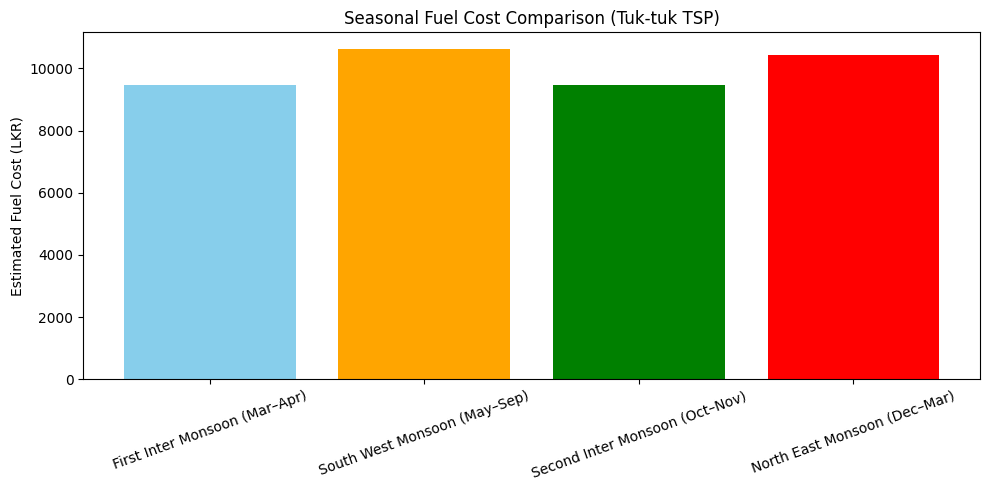

In [ ]:
# ===============================
# Seasonal Fuel Cost Comparison for Four Weather Seasons
# ===============================
import matplotlib.pyplot as plt
import pandas as pd

# Route (precomputed optimal sequence)
route_names = ["Airport","Galle","Kandy","Dambulla","Sigiriya","Polonnaruwa","Anuradhapura","Airport"]
route_str = " → ".join(route_names)

# Distances for each arc (km) along the route
dists = [148,230,73,19,52,101,169]  # match route sequence

# Tuk-tuk parameters
eta = 25.0  # km per litre
price = 299.0  # LKR per litre

# Compute base fuel costs per arc
base_costs = [(d/eta)*price for d in dists]

# ---- Seasonality multipliers per segment
# 1. First Inter Monsoon (Mar–Apr): minimal effect
mult_fim = [1.0]*7

# 2. South West Monsoon (May–Sep): south & west affected
mult_swm = [1.25,1.15,1.0,1.0,1.0,1.0,1.15]

# 3. Second Inter Monsoon (Oct–Nov): minimal effect
mult_sim = [1.0]*7

# 4. North East Monsoon (Dec–Mar): north & north-central affected
mult_nem = [1.0,1.0,1.15,1.25,1.25,1.25,1.15]

# Compute total fuel cost per season
total_fim = sum([c*m for c,m in zip(base_costs,mult_fim)])
total_swm = sum([c*m for c,m in zip(base_costs,mult_swm)])
total_sim = sum([c*m for c,m in zip(base_costs,mult_sim)])
total_nem = sum([c*m for c,m in zip(base_costs,mult_nem)])

# Build DataFrame
df = pd.DataFrame({
    "Season": [
        "First Inter Monsoon (Mar–Apr)",
        "South West Monsoon (May–Sep)",
        "Second Inter Monsoon (Oct–Nov)",
        "North East Monsoon (Dec–Mar)"
    ],
    "Month": ["Apr","Jul","Oct","Jan"],
    "Route": [route_str]*4,
    "FuelCost_LKR": [total_fim, total_swm, total_sim, total_nem]
})

# Print table
print(df.to_string(index=False))

# Plot bar chart
plt.figure(figsize=(10,5))
plt.bar(df['Season'], df['FuelCost_LKR'], color=['skyblue','orange','green','red'])
plt.ylabel('Estimated Fuel Cost (LKR)')
plt.title('Seasonal Fuel Cost Comparison (Tuk-tuk TSP)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# ===============================
# Optimized route (from TSP results)
# ===============================
route_nodes = [0, 5, 6, 3, 4, 2, 1, 0]  # Node indices
route_names = ["Katunayake Airport",
               "Southern City of Galle",
               "Sacred City of Kandy",
               "Golden Temple of Dambulla",
               "Ancient City of Sigiriya",
               "Sacred City of Polonnaruwa",
               "Sacred City of Anuradhapura",
               "Katunayake Airport"]

# Distance matrix (km) from Katunayake Airport to UNESCO sites
dist_matrix = [
    [0, 169, 195, 128, 145, 148, 105],
    [169, 0, 101, 65, 72, 309, 138],
    [195, 101, 0, 67, 52, 330, 140],
    [128, 65, 67, 0, 19, 262, 73],
    [145, 72, 52, 19, 0, 279, 92],
    [148, 309, 330, 262, 279, 0, 230],
    [105, 138, 140, 73, 92, 230, 0]
]

# Tuk-tuk parameters
fuel_efficiency = 25  # km per litre
fuel_price = 299      # LKR per litre

# ===============================
# Compute segment distances and fuel costs
# ===============================
segment_from = []
segment_to = []
segment_distance = []
segment_fuel_cost = []

for i in range(len(route_nodes)-1):
    from_node = route_nodes[i]
    to_node = route_nodes[i+1]
    distance = dist_matrix[from_node][to_node]
    fuel_cost = (distance / fuel_efficiency) * fuel_price

    segment_from.append(from_node)
    segment_to.append(to_node)
    segment_distance.append(distance)
    segment_fuel_cost.append(round(fuel_cost, 2))  # Round to 2 decimals

# ===============================
# Build DataFrame for Table 3
# ===============================
df_table3 = pd.DataFrame({
    "From": segment_from,
    "To": segment_to,
    "Distance (km)": segment_distance,
    "Fuel Cost (LKR)": segment_fuel_cost
})

# Add total row
total_distance = sum(segment_distance)
total_fuel_cost = sum(segment_fuel_cost)
df_total = pd.DataFrame({
    "From": ["Total"],
    "To": [""],
    "Distance (km)": [total_distance],
    "Fuel Cost (LKR)": [round(total_fuel_cost, 2)]
})

df_table3 = pd.concat([df_table3, df_total], ignore_index=True)

# ===============================
# Display table
# ===============================
print(df_table3)


    From To  Distance (km)  Fuel Cost (LKR)
0      0  5            148          1770.08
1      5  6            230          2750.80
2      6  3             73           873.08
3      3  4             19           227.24
4      4  2             52           621.92
5      2  1            101          1207.96
6      1  0            169          2021.24
7  Total               792          9472.32


In [ ]:
import pandas as pd

# ---- Optimized route distances in km (as per TSP)
route_distances = [148, 230, 73, 19, 52, 101, 169]  # matches route sequence
route_nodes = ["0→5", "5→6", "6→3", "3→4", "4→2", "2→1", "1→0"]

# ---- Tuk-tuk parameters
fuel_efficiency = 25.0  # km per liter
fuel_price = 299.0      # LKR per liter

# ---- Seasonality multipliers for each arc
# 1. First Inter Monsoon (Mar–Apr)
mult_fim = [1.0]*7

# 2. South-West Monsoon (May–Sep)
mult_swm = [1.25, 1.15, 1.0, 1.0, 1.0, 1.0, 1.15]

# 3. Second Inter Monsoon (Oct–Nov)
mult_sim = [1.0]*7

# 4. North-East Monsoon (Dec–Mar)
mult_nem = [1.0, 1.0, 1.15, 1.25, 1.25, 1.25, 1.15]

# ---- Function to calculate total fuel cost per season
def calc_fuel_cost(distances, multipliers, efficiency, price):
    return sum((d / efficiency) * price * m for d, m in zip(distances, multipliers))

# ---- Calculate fuel costs for all seasons
season_names = [
    "First Inter Monsoon (Mar–Apr)",
    "South-West Monsoon (May–Sep)",
    "Second Inter Monsoon (Oct–Nov)",
    "North-East Monsoon (Dec–Mar)"
]

multipliers_list = [mult_fim, mult_swm, mult_sim, mult_nem]
fuel_costs = [calc_fuel_cost(route_distances, m, fuel_efficiency, fuel_price) for m in multipliers_list]

# ---- Build DataFrame
df_seasonal = pd.DataFrame({
    "Season": season_names,
    "Total Fuel Cost (LKR)": fuel_costs
})

# Format with commas
df_seasonal["Total Fuel Cost (LKR)"] = df_seasonal["Total Fuel Cost (LKR)"].map('{:,.2f}'.format)

# Display
print(df_seasonal)


                           Season Total Fuel Cost (LKR)
0   First Inter Monsoon (Mar–Apr)              9,472.32
1    South-West Monsoon (May–Sep)             10,630.65
2  Second Inter Monsoon (Oct–Nov)              9,472.32
3    North-East Monsoon (Dec–Mar)             10,420.75
